In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

%matplotlib inline
plt.style.use('ggplot')

In [2]:
nba = pd.read_csv('../../data/nba_train.csv')

In [4]:
nba.tail()

,SeasonEnd,Team,Playoffs,W,PTS,oppPTS,FG,FGA,2P,2PA,3P,3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV
830,2011,Sacramento Kings,0,24,8151,8589,3134,6979,2706,5702,428,1277,1455,1981,1071,2526,1675,608,391,1324
831,2011,San Antonio Spurs,1,61,8502,8034,3148,6628,2463,4901,685,1727,1521,1984,829,2603,1836,602,372,1101
832,2011,Toronto Raptors,0,22,8124,8639,3144,6755,2799,5664,345,1091,1491,1976,963,2343,1795,581,350,1206
833,2011,Utah Jazz,0,39,8153,8303,3064,6590,2629,5334,435,1256,1590,2061,898,2338,1921,629,484,1175
834,2011,Washington Wizards,0,23,7977,8584,3048,6888,2656,5706,392,1182,1489,1999,1013,2374,1592,665,502,1258


In [18]:
# rename 2/3P* columns because patsy does not play nice with var that start with nums
nba.rename(columns={'2P':'X2P', '2PA':'X2PA', '3P':'X3P', '3PA':'X3PA'}, inplace=True)

### Variable Reference
`The post fix A stands for "total tries attempted" ; the matching var sans postfix records successful attempts.
(ex. FG : successful 2/3 pointers  | FGA : total 2/3 pointer attempts) `
- **PTS** : points scored
- **oppPTS** : opponent points scored
- **FG** : Field goals (2 & 3 pointers)
- **2P**, 3P : 2,3 pointers
- **FT** : free throws
- **ORB**/DRB : offensive/defensive rebounds
- **AST** : assists
- **STL** : steals
- **BLK** : blocks
- **TOV** : turnovers

### The Magic Number - How many games a team needs to win to get to the Playoffs ?

In [15]:
pd.crosstab(nba.Playoffs, nba.W)

W,11,12,13,14,15,16,17,18,19,20,...,61,62,63,64,65,66,67,69,72,All
Playoffs,,,,,,,,,,,,,,,,,,,,,
0,2,2,2,2,10,2,11,5,10,10,...,0,0,0,0,0,0,0,0,0,355
1,0,0,0,0,0,0,0,0,0,0,...,10,13,7,3,3,2,4,1,1,480
All,2,2,2,2,10,2,11,5,10,10,...,10,13,7,3,3,2,4,1,1,835


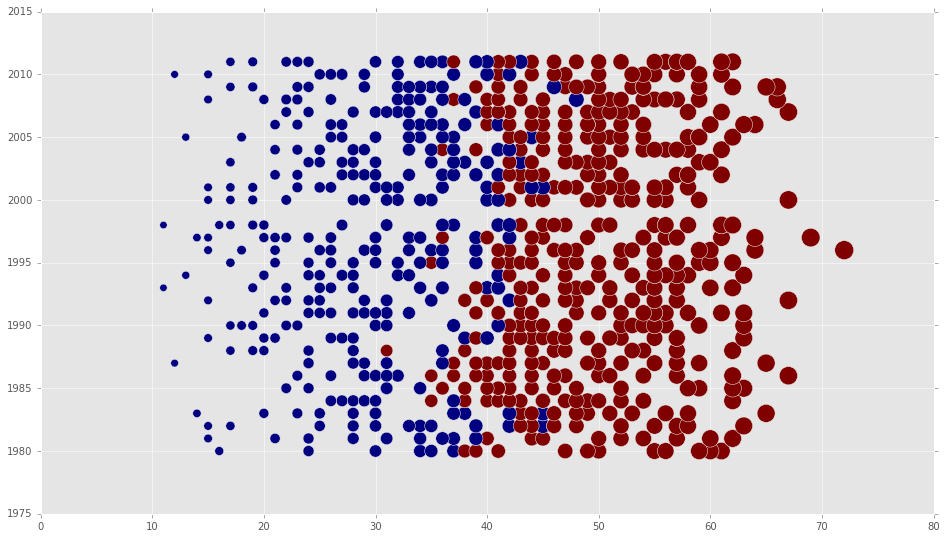

In [16]:
plt.figure(figsize=(14, 6))
plt.scatter(nba.W, nba.SeasonEnd, s=5*nba.W, c=nba.Playoffs)


In [3]:
playoffs = nba[nba.Playoffs == 1]
losers = nba[nba.Playoffs == 0]

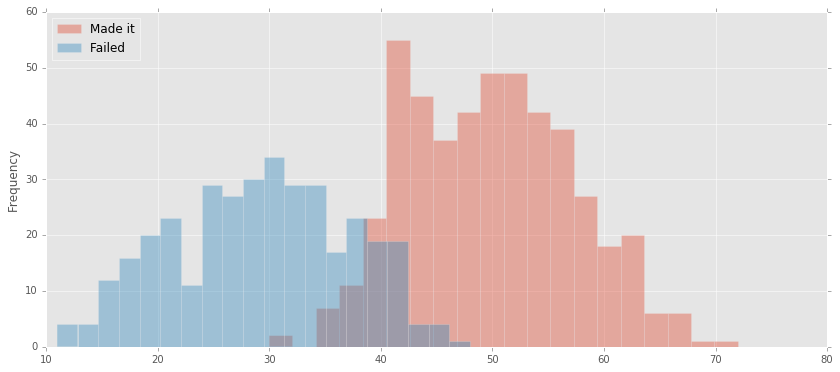

In [26]:
plt.subplots(1,1, figsize=(14,6))
plt.subplot(1,1,1)
playoffs.W.plot.hist(bins = 20, alpha=0.4, label='Made it')
losers.W.plot.hist(bins = 20, alpha=0.4, label='Failed')
plt.legend(loc=2)

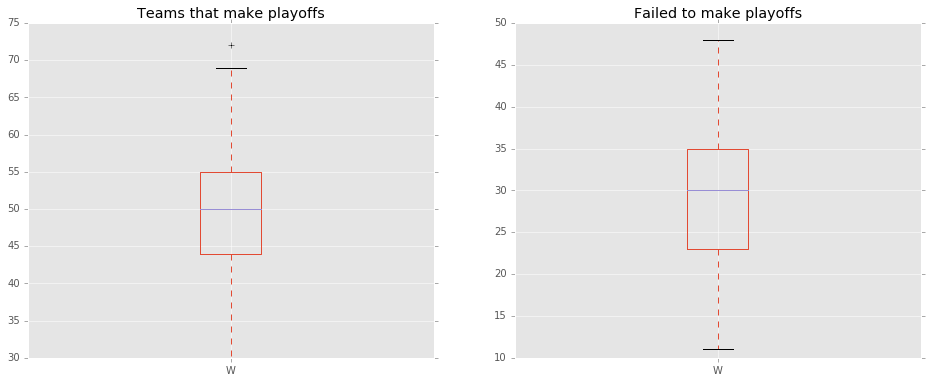

In [27]:
plt.subplots(1,2, figsize=(16,6))
plt.subplot(1,2,1)
playoffs.W.plot.box()
plt.title('Teams that make playoffs')
plt.subplot(1,2,2)
losers.W.plot.box()
plt.title('Failed to make playoffs')

In [38]:
# the range of years in the dataset injects variability
# assumed difference between divisions
losers.W.value_counts().sort_index(ascending=False)[:5]

48    1
46    1
45    3
44    2
43    2
Name: W, dtype: int64

In [41]:
'''Calculate the games won at a given percentile (95%) , i.e. based on past data, 
there is only 5% probability that the team with 41 wins doesnt make it to the playoffs ; 
there is only 1% probability that the team with 45 wins doesnt make it to the playoffs ; 
'''
import scipy.stats as stats
stats.scoreatpercentile(losers.W, per=95) # 41
stats.scoreatpercentile(losers.W, per=99) # 45

41.0

### The Points Differential and its correlation to Wins

In [19]:
# create a new column that shows the Points Differential
nba['PTSDiff'] = nba.PTS - nba.oppPTS
nba.tail()

,SeasonEnd,Team,Playoffs,W,PTS,oppPTS,FG,FGA,X2P,X2PA,...,X3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PTSDiff
830,2011,Sacramento Kings,0,24,8151,8589,3134,6979,2706,5702,...,1277,1455,1981,1071,2526,1675,608,391,1324,-438
831,2011,San Antonio Spurs,1,61,8502,8034,3148,6628,2463,4901,...,1727,1521,1984,829,2603,1836,602,372,1101,468
832,2011,Toronto Raptors,0,22,8124,8639,3144,6755,2799,5664,...,1091,1491,1976,963,2343,1795,581,350,1206,-515
833,2011,Utah Jazz,0,39,8153,8303,3064,6590,2629,5334,...,1256,1590,2061,898,2338,1921,629,484,1175,-150
834,2011,Washington Wizards,0,23,7977,8584,3048,6888,2656,5706,...,1182,1489,1999,1013,2374,1592,665,502,1258,-607


In [22]:
# check for possible correlations between wins & other variables
# corr() returns dataframe, so filter to Wins column
'''correlations between :
1. PTS - oppPTS cumulative , i.e. PTSDiff
2. DRB + BLK , i.e total defense
'''
nba.corr().loc[:, 'W']

SeasonEnd    0.000000
Playoffs     0.798676
W            1.000000
PTS          0.298826
oppPTS      -0.331573
FG           0.190396
FGA         -0.071446
X2P          0.069279
X2PA        -0.087037
X3P          0.119045
X3PA         0.083286
FT           0.204906
FTA          0.161887
ORB         -0.095737
DRB          0.470897
AST          0.320052
STL          0.116194
BLK          0.203921
TOV         -0.243186
PTSDiff      0.970743
Name: W, dtype: float64

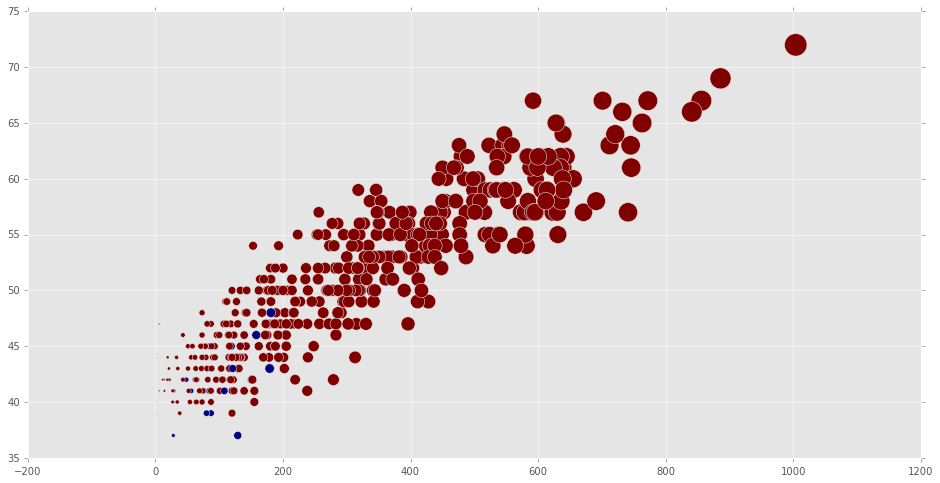

In [30]:
plt.figure(figsize=(16, 8))
plt.scatter(nba.PTSDiff, nba.W, s=0.5*nba.PTSDiff, c=nba.Playoffs)

In [52]:
# Linear Regression (one variable) - Wins Model
W_model = ols('W ~ PTSDiff', nba).fit()
print W_model.summary() 

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.361e+04
Date:                Thu, 29 Sep 2016   Prob (F-statistic):               0.00
Time:                        22:40:43   Log-Likelihood:                -2118.0
No. Observations:                 835   AIC:                             4240.
Df Residuals:                     833   BIC:                             4249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     41.0000      0.106    387.027      0.0

In [44]:
# Predict required  Points Differential for a 42-win regular season based on the OLS model  
intcpt, slope = W_model.params
hyp_PTSDiff = (42 - intcpt)/slope
hyp_PTSDiff    # result is 133.5 , the claim was rounded up to 135

30.687712099702548

### Investigating which variables best indicate a team's ability to score points
-  **We use linear regression to verify which team stats are more important to predict points scored?**

In [23]:
# check for colinearity between PTS Vs other variables
nba.corr().loc[:, 'PTS']

SeasonEnd   -0.639528
Playoffs     0.270601
W            0.298826
PTS          1.000000
oppPTS       0.789075
FG           0.941955
FGA          0.793979
X2P          0.825725
X2PA         0.708361
X3P         -0.489949
X3PA        -0.515198
FT           0.697484
FTA          0.655059
ORB          0.496921
DRB          0.090291
AST          0.759889
STL          0.430990
BLK          0.152055
TOV          0.427138
PTSDiff      0.309379
Name: PTS, dtype: float64

In [51]:
# Linear Regression (one variable) - Points scored Model
P_model = ols('PTS ~ X2PA + X3PA + FTA + AST + ORB ', nba).fit()
print P_model.summary() 

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     1462.
Date:                Thu, 29 Sep 2016   Prob (F-statistic):               0.00
Time:                        22:40:38   Log-Likelihood:                -5545.2
No. Observations:                 835   AIC:                         1.110e+04
Df Residuals:                     829   BIC:                         1.113e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -2039.2852    163.550    -12.469      0.0

In [34]:
# squared sum error (SSE) & Root mean squared error (RSME)
SSE = np.sum((P_model.resid)**2)
RMSE = np.sqrt(SSE / nba.shape[0])
nba.PTS.mean(), nba.PTS.std(),  RMSE  # Mean is 8370 pts, Stdev is 581 pts,  RMSE is 185 pts

(8370.239520958085, 581.0401139540635, 185.31335830388471)

### Predicting Points Scored  and Wins for the 2012-13 season, using our OLS models & up to 2011 team stats
` We will be using our test data set that contains the team stats for the 2012-13 season`

In [53]:
# load test data
test_nba = pd.read_csv('../../data/nba_test.csv')
# rename 2/3P* columns because patsy does not play nice with var that start with nums
test_nba.rename(columns={'2P':'X2P', '2PA':'X2PA', '3P':'X3P', '3PA':'X3PA'}, inplace=True)
# create a new column that shows the Points Differential
test_nba['PTSDiff'] = test_nba.PTS - test_nba.oppPTS
test_nba.head()

,SeasonEnd,Team,Playoffs,W,PTS,oppPTS,FG,FGA,X2P,X2PA,...,X3PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,PTSDiff
0,2013,Atlanta Hawks,1,44,8032,7999,3084,6644,2378,4743,...,1901,1158,1619,758,2593,2007,664,369,1219,33
1,2013,Brooklyn Nets,1,49,7944,7798,2942,6544,2314,4784,...,1760,1432,1958,1047,2460,1668,599,391,1206,146
2,2013,Charlotte Bobcats,0,21,7661,8418,2823,6649,2354,5250,...,1399,1546,2060,917,2389,1587,591,479,1153,-757
3,2013,Chicago Bulls,1,45,7641,7615,2926,6698,2480,5433,...,1265,1343,1738,1026,2514,1886,588,417,1171,26
4,2013,Cleveland Cavaliers,0,24,7913,8297,2993,6901,2446,5320,...,1581,1380,1826,1004,2359,1694,647,334,1149,-384


In [43]:
# Using model to assess projected Points Scored model
proj_PTS = P_model.predict(test_nba)
cproj_PTS

array([ 8101.11971191,  7756.84907215,  7963.01934634,  7772.47661843,
        8009.22364957,  8259.36162042,  8617.75840561,  7807.02000719,
        8116.83296797,  8627.39155271,  8105.57105562,  8520.1499245 ,
        7545.09656832,  8053.07672614,  8289.84934918,  8173.52911077,
        7486.68656164,  7870.43136514,  8212.94121467,  7749.86990119,
        7729.11698225,  7950.71021789,  7933.20464825,  8156.72585911,
        8359.44967283,  8004.35836781,  7987.90793513,  7872.50001497])

In [48]:
# Compute out-of-sample R-squared of the Points Scored  model
SSE_PTS = np.sum((test_nba.PTS - proj_PTS)**2)
SST_PTS = np.sum((test_nba.PTS - test_nba.PTS.mean())**2)
RSME_PTS = np.sqrt(SSE_PTS / test_nba.shape[0])
R_squared_PTS = 1 - SSE_PTS/SST_PTS
RSME_PTS, R_squared_PTS

(190.83217341363726, 0.6712621896780298)

In [54]:
# Using model to assess projected Wins model
proj_W = W_model.predict(test_nba)
proj_W

array([ 42.07534898,  45.75760459,  16.33214605,  41.84724465,
        28.4868482 ,  39.40326969,  54.58850079,  30.34426917,
        43.3788023 ,  50.28710485,  58.23817006,  44.09570162,
        52.07935316,  62.01818467,  36.99188106,  34.67825143,
        30.6701325 ,  52.30745749,  65.60268128,  22.32803129,
        32.07134481,  23.7292436 ,  32.52755347,  27.96546687,
        58.10782473,  37.05705373,  40.77189567,  34.22204277])

In [55]:
# Compute out-of-sample R-squared of the Wins model
SSE_W = np.sum((test_nba.W - proj_W)**2)
SST_W = np.sum((test_nba.W - test_nba.W.mean())**2)
R_squared_W = 1 - SSE_W/SST_W
RSME_W = np.sqrt(SSE_W / test_nba.shape[0])
RSME_W,  R_squared_W

(3.1007510990024083, 0.9417054654092641)

**While Model Rsquared always increases by adding more exon (dependent) variables, the same is not true for Test Rsquared. This means that out-of-sample Rsquared can be an indicator of a good model :**
- **Keep adding dependent variables ; once test Rsquared starts dropping, we've gone too far.**

`The test Rsquared can be negative ; don't freak out !!`